# Extended Data Figure 3
Additional Mutation Rates

In [23]:
source("func.R")
library("patchwork")
library("ggpubr")
library("rstatix")

Function to get L1 distance of any shared markers

In [24]:
get_l1_r_for_all_combination <- function(i, combos, markerlengths) {


  sample_a <- combos$a[i]
  sample_b <- combos$b[i]

  markerlength_tbl_a <- markerlengths %>%
      dplyr::filter(sample == sample_a)
  
 markerlength_tbl_b <- markerlengths %>%
     dplyr::filter(sample == sample_b)
 
 common_markers <- intersect(markerlength_tbl_a$marker, markerlength_tbl_b$marker)

  markerlengths_a  <- markerlength_tbl_a %>% 
    dplyr::filter(marker%in%common_markers) %>% 
    arrange(marker)  %>% 
    pull(length)

  markerlengths_b  <- markerlength_tbl_b %>% 
    dplyr::filter(marker%in%common_markers) %>% 
    arrange(marker)  %>% 
    pull(length)
  
  n_markers_a  <- length(markerlengths_a)
  n_markers_b  <- length(markerlengths_b)
  
  if (n_markers_a != n_markers_b) (error)
  
  l1  <- sum(abs(markerlengths_a - markerlengths_b))/n_markers_a
    
  list(a = sample_a, b = sample_b, l1 = l1, marker = n_markers_a)
  
}


## A549
LUAD cell line

In [25]:
# directroy of all results
dir_list_a549 <-  list.files("../data/invitro_mu/",
                        pattern= "A549", full.names = TRUE)

In [26]:
l <- lapply(
    dir_list_a549,
    get_markerlengths_unsubtracted
)
markerlengths_raw_a549 <- bind_rows(l)

A549



### Heatmap

In [56]:
markerlengths_a549 <- markerlengths_raw_a549 %>%
    group_by(subject, marker) %>%
    filter(any(str_detect(sample, "Root2")), marker!="JF06") %>% 
    mutate(length = length - length[sample==str_subset(sample, "Root2")[1]]) %>% 
    ungroup()

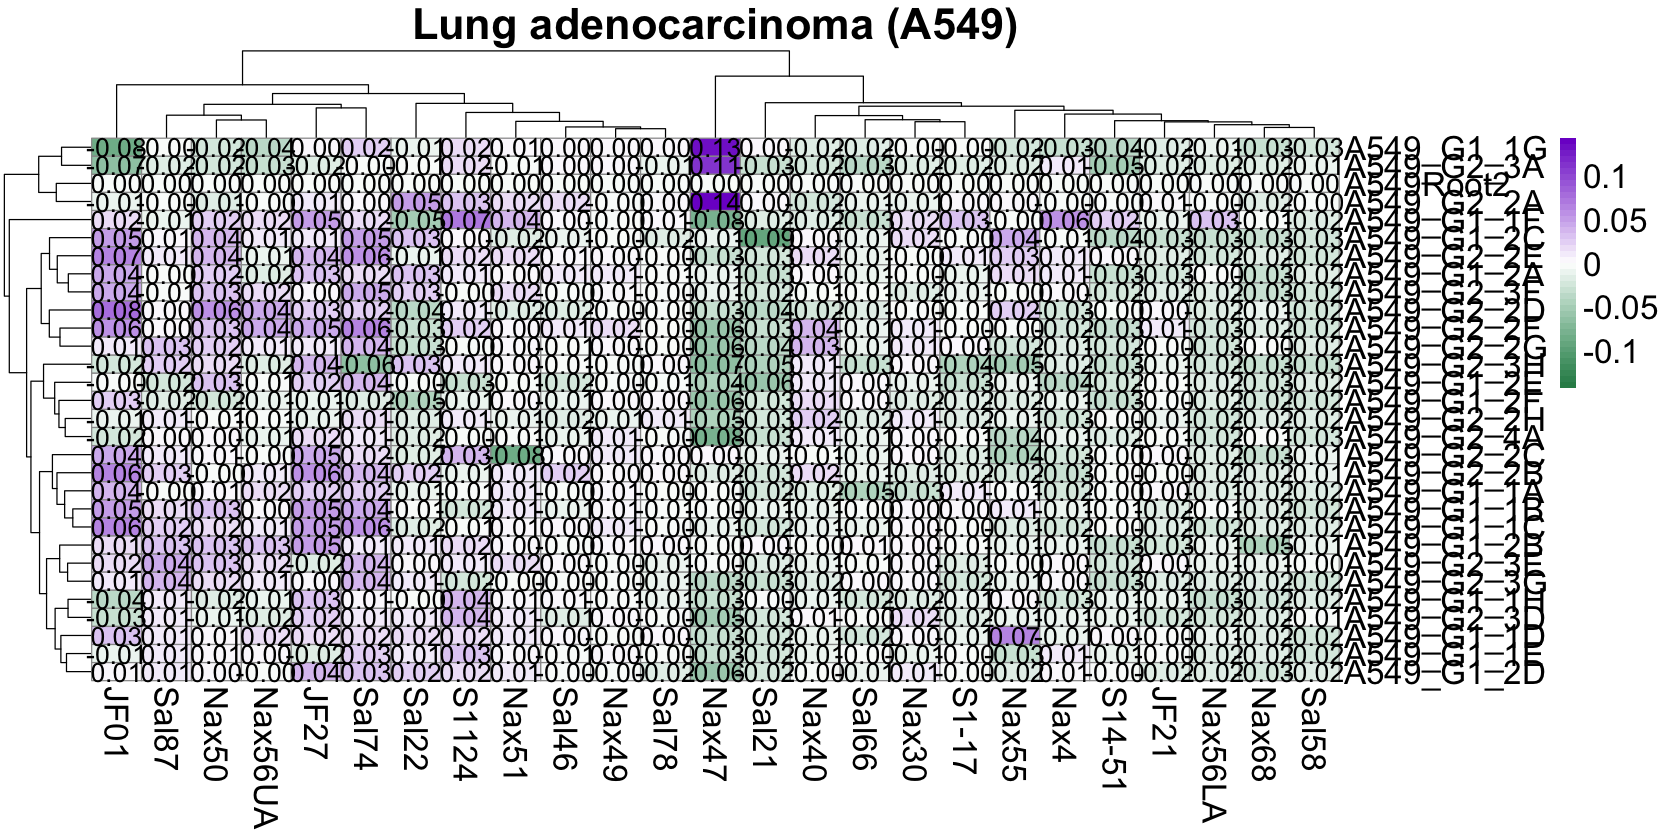

In [57]:
filtered_matrix <- markerlengths_a549 %>%
        select(-subject) %>%
        filter(sample!="A549Root1") %>% 
        pivot_wider(names_from = marker, 
        values_from = length) %>% 
        column_to_rownames("sample") %>%
        as.matrix()
    
    minmax <- max(abs(filtered_matrix), na.rm = TRUE)
    
plot_title <- "Lung adenocarcinoma (A549)"
options(repr.plot.width=14, repr.plot.height=7)
    hm <- pheatmap::pheatmap(filtered_matrix,
        clustering_distance_rows = "manhattan",
        clustering_distance_cols = "manhattan",
        display_numbers = TRUE, number_color = "black", fontsize = 20,
        color = colorRampPalette(c("seagreen", "white", "purple3"))(42),
        na_col = "yellow", breaks = seq(-minmax, minmax, length.out = 43),
        main = plot_title
    )
ggsave("../plots/Supplementary_figures/a549_hm.pdf", hm, height=13, width=30)

## L1 Distance

In [58]:
# find samples
samples <- markerlengths_a549$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_extract(a, "^[:upper:]+[:digit:]+"),
          sample_b=str_extract(b, "^[:upper:]+[:digit:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [59]:
l1_l <- lapply(1:nrow(combos), get_l1_r_for_all_combination, combos, markerlengths_a549)

In [60]:
a549_l1_tbl <- rbindlist(l1_l)

In [61]:
a549_data <- a549_l1_tbl %>%
    filter(a != "A549Root1", b != "A549Root1") %>%
    mutate(divisions = case_when(
        a == "A549Root2" & str_detect(b, "_G1_") ~ 21.33756093,
        a == "A549Root2" & str_detect(b, "_G2_") ~ 42.16817502,
        str_detect(a, "_G1_") & str_detect(b, "_G1_") ~ 21.33756093 * 2,
        str_detect(a, "_G2_") & str_detect(b, "_G2_") ~ 42.16817502 * 2,
        str_detect(a, "_G1_") & str_detect(b, "_G2_") ~ 21.33756093 + 42.16817502,
        str_detect(b, "_G1_") & str_detect(a, "_G2_") ~ 21.33756093 + 42.16817502
    ), days = case_when(
        a == "A549Root2" & str_detect(b, "_G1_") ~ 22,
        a == "A549Root2" & str_detect(b, "_G2_") ~ 49,
        str_detect(a, "_G1_") & str_detect(b, "_G1_") ~ 22 * 2,
        str_detect(a, "_G2_") & str_detect(b, "_G2_") ~ 49 * 2,
        str_detect(a, "_G1_") & str_detect(b, "_G2_") ~ 22 + 49,
        str_detect(b, "_G1_") & str_detect(a, "_G2_") ~ 22 + 49
    ))

Bootstrap

In [62]:
# finding combination of samples to bootstrap

get_boot_combos <- function(markerlengths) {
      
      # find samples
      samples <- markerlengths %>% 
            pull(sample) %>%
            unique()

      combos_wide <- combn(samples, m = 2) %>% as.data.frame()

      ## make combo table longer
      combos_long <- data.frame(a = as.character(combos_wide[1, ]), b = as.character(combos_wide[2, ]))
}


In [63]:
l1_bootstrap <- function(i, combos, markerlengths) {

  sample_a <- combos$a[i]
  sample_b <- combos$b[i]

  markerlength_tbl_a <- markerlengths %>%
      dplyr::filter(sample == sample_a)
  
 markerlength_tbl_b <- markerlengths %>%
     dplyr::filter(sample == sample_b)
 
  markerlengths_a  <- c(markerlength_tbl_a$length)
  names(markerlengths_a) <- markerlength_tbl_a$marker

  markerlengths_b  <- c(markerlength_tbl_b$length)
  names(markerlengths_b) <- markerlength_tbl_b$marker
  
  common_markers <- intersect(markerlength_tbl_a$marker, markerlength_tbl_b$marker)
  marker_length <- length(common_markers)
  boot_markers <- sample(common_markers, marker_length, replace = T)


  markerlengths_a <- markerlengths_a[boot_markers]
  markerlengths_b <- markerlengths_b[boot_markers]

  l1  <- sum(abs(markerlengths_a - markerlengths_b))/marker_length

  list(a = sample_a, b = sample_b, l1 = l1, marker = marker_length)
  
}


In [64]:
# function to the find the MRCA of a specific marker combination

boot_mu <- function(i, subject_markers, boot_combos, generations_tbl) {

        l1_comb_boot <- lapply(1:nrow(boot_combos), l1_bootstrap, boot_combos, subject_markers) %>%
            bind_rows()

        l1_gen_tbl <- l1_comb_boot %>%
            left_join(generations_tbl)
        coef((lm(l1_gen_tbl$l1 ~ l1_gen_tbl$divisions)))[[2]]
        
    }

In [65]:
bootstrap_mu <- function(markerlengths, generations_tbl) {
    
    # getting combos to bootstrap through
    boot_combos <- get_boot_combos(markerlengths)

    # number of bootstrap reps
    reps <- 1000
    mrca_boot <- parallel::mclapply(1:reps, boot_mu, markerlengths, boot_combos, generations_tbl)

    return(mrca_boot)
}

In [66]:
a549_just_divs <- a549_data %>%
    select(a, b, divisions) 
markerlengths_a549_boot <- markerlengths_a549 %>%
    filter(sample!="A549Root1") 

In [67]:
a549_boot <-bootstrap_mu(markerlengths_a549_boot, a549_just_divs)

In [68]:
quantile(unlist(a549_boot), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(a549_boot), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"9.275993e-06"

97.5% 
"5.742767e-05"

In [69]:
lower_ci_a549 <- sub("e", " %*% 10^", quantile(unlist(a549_boot), 0.025) %>%
    format(scientific = TRUE))
upper_ci_a549 <- sub("e", " %*% 10^", quantile(unlist(a549_boot), 0.975) %>%
    format(scientific = TRUE))

Manual entering bootstrap values from previous run to reduce computation time.

In [72]:
lower_ci_a549 <- sub("e", " %*% 10^", "9.28e-06")
upper_ci_a549 <- sub("e", " %*% 10^", "5.74e-05")

In [73]:
# calculating mutation rate based on slope
mu_a549 <- coef((lm(a549_data$l1 ~ a549_data$divisions)))[2]
mu_a549_form <- sub("e", " %*% 10^", format(mu_a549, digits=3, scientific = TRUE))
mu_a549_annotation <- paste0("mu == ", mu_a549_form)
mu_ci_a549_annotation <- paste0("(", lower_ci_a549, "-", upper_ci_a549,")")

`geom_smooth()` using formula = 'y ~ x'
Saving 8 x 7 in image
`geom_smooth()` using formula = 'y ~ x'


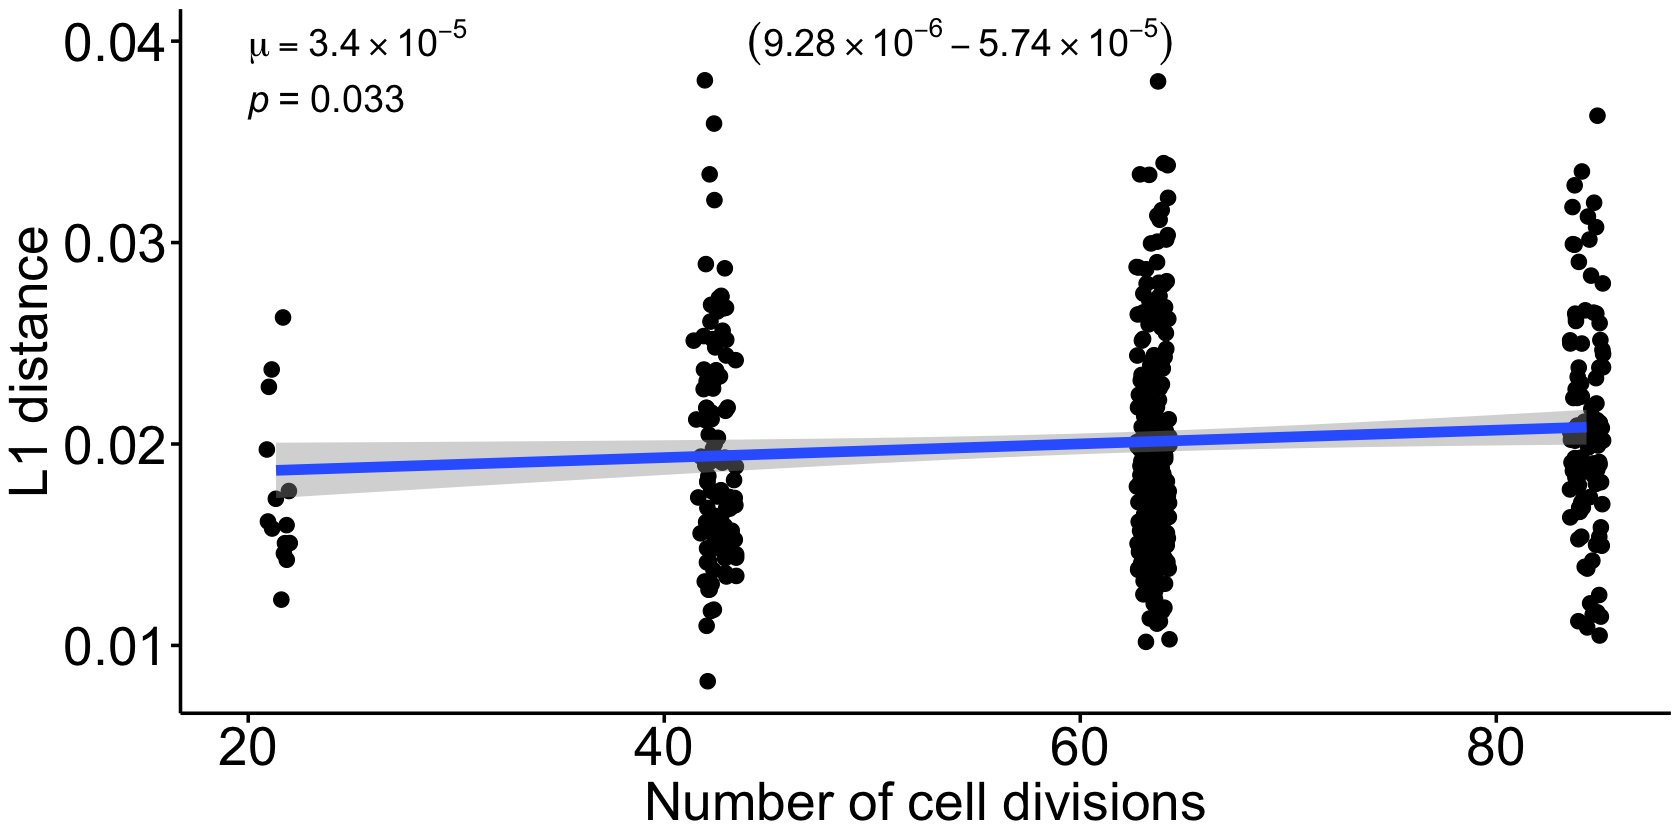

In [75]:
a549_data %>% 
    ggplot(aes(divisions, l1)) +
    geom_jitter(size = 4,width = 0.8) +
    #ggbeeswarm::geom_quasirandom(size = 4,width = 1) +
    geom_smooth(method = "lm", size = 3) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    ) +
    annotate("text", 20, 0.04, label = mu_a549_annotation, size = 8, parse = TRUE, hjust = 0) +
        annotate("text", 44, 0.04, label = mu_ci_a549_annotation, size = 8, parse = TRUE, hjust = 0) +
        stat_cor(aes(label = ..p.label..), size = 8, label.y = 0.037)
    
ggsave("../plots/Figure2/mu_a549.pdf", width = 8)

In [108]:
markerlengths_a549 %>%
    filter(!str_detect(sample, "Root")) %>%
    select(sample) %>% 
    distinct() %>% 
    mutate(type = ifelse(str_detect(sample, "G1"), "G1", "G2")) %>% 
    count(type)

type,n
<chr>,<int>
G1,14
G2,15


## HMEC
Normal breast epithelial cell line

In [4]:
# directroy of all results
dir_list <-  list.files("../data/invitro_mu/",
                        pattern= "HMEC", full.names = TRUE)

In [5]:
# getting markerlengths without subtracting the normal length
get_markerlengths_hmec  <- function(dir) { 

  subject <- str_split(dir, "/") %>%
    purrr::map(tail, n = 1) %>%
    unlist() %>%
    str_split("_") %>%
    purrr::map(1) %>%
    unlist()

  message(subject)

  ## path to poly-G raw data directory (marker length files)
  marker_dir <- list.files(dir, pattern = "repre_repli", full.names = TRUE)

  ## load marker lengths and get the average length of each marker in each sample
  get_markers <- function(marker_dir) {

  marker <- suppressMessages(read_tsv(marker_dir))
  
  # getting the marker name
  int_file <- tail(str_split(marker_dir, "/")[[1]], 1) 
  marker_name <- head(str_split(int_file, "_")[[1]], 1)

  cols <- NCOL(marker) +1 

  marker  %>% 
    rowid_to_column("length")  %>% 
    pivot_longer(cols=c(2:cols), names_to="sample", values_to="Frequency")  %>% 
    group_by(sample)  %>% 
    mutate(Frequency=Frequency/sum(Frequency),
            sample=str_remove(sample, "_[1-3]$")) %>%
    summarize(length = sum(length * Frequency)) %>%
    mutate(marker=marker_name) 
    
  }
  
  marker_files <- list.files(marker_dir, full.names = TRUE)

  markers <- lapply(marker_files, get_markers)
  markers <- bind_rows(markers)

  markers <- markers %>% 
      ungroup %>% 
      as.data.table 
      

    markers$subject <- subject

 return(markers)
}

In [6]:
l <- lapply(
    dir_list,
    get_markerlengths_hmec
)
markerlengths_hmec_raw <- bind_rows(l)

HMEC

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols)

  # Now:
  data %>% select(all_of(cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


### Heatmap

In [7]:
markerlengths_hmec <- markerlengths_hmec_raw %>%
    group_by(subject, marker) %>%
    filter(any(str_detect(sample, "Root1"))) %>% 
    mutate(length = length - length[sample==str_subset(sample, "Root1")[1]]) %>% 
    ungroup()

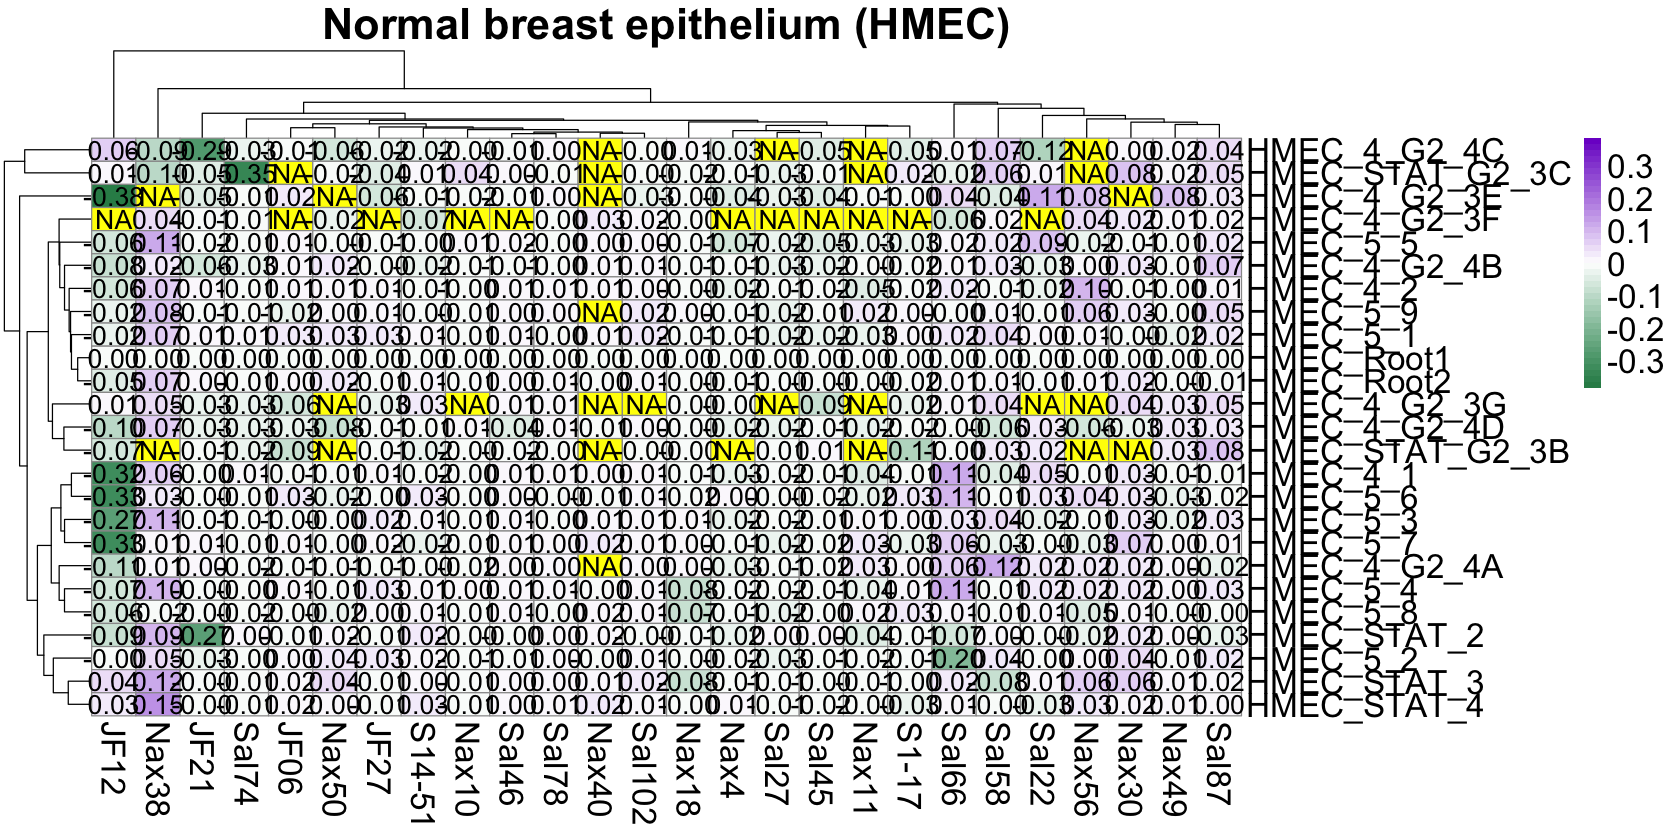

In [76]:
filtered_matrix <- markerlengths_hmec %>%
        select(-subject) %>%
        pivot_wider(names_from = marker, 
        values_from = length) %>% 
        column_to_rownames("sample") %>%
        as.matrix()
    
    minmax <- max(abs(filtered_matrix), na.rm = TRUE)
    
plot_title <- "Normal breast epithelium (HMEC)"
options(repr.plot.width=14, repr.plot.height=7)
    hm <- pheatmap::pheatmap(filtered_matrix,
        clustering_distance_rows = "manhattan",
        clustering_distance_cols = "manhattan",
        display_numbers = TRUE, number_color = "black", fontsize = 20,
        color = colorRampPalette(c("seagreen", "white", "purple3"))(42),
        na_col = "yellow", breaks = seq(-minmax, minmax, length.out = 43),
        main = plot_title
    )
ggsave("../plots/Supplementary_figures/hmec_hm.pdf", hm, height=13, width=30)

## L1 Distance

In [8]:
# find samples
samples <- markerlengths_hmec$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long #%>%
    #filter(a!="HMEC_Root2", b!="HMEC_Root2")

In [9]:
l1_l_hmec <- lapply(1:nrow(combos), get_l1_r_for_all_combination, combos, markerlengths_hmec)

In [10]:
l1_tbl_hmec <- rbindlist(l1_l_hmec) %>%
        filter(a != "HMEC_Root2" , b != "HMEC_Root2") 

Annotating divisions:

In [11]:
hmec_divs_numbers <- read_tsv("../data/HMEC_divs_numbers.txt") %>%
    mutate(days=days+41)

Rows: 5 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): sample
dbl (2): divs, days

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
hmec_data <- l1_tbl_hmec %>%
    filter(a!="HMEC_Root2", b!="HMEC_Root2") %>% 
    mutate(
        type_a = str_remove(str_remove(a, "HMEC_"), "_[:digit:].*$"),
        type_b = str_remove(str_remove(b, "HMEC_"), "_[:digit:].*$"),
        across(type_a:type_b, ~ case_when(.x == "4" ~ "4_G1", .x == "STAT" ~ "STAT_G1", TRUE ~ .x))
    ) %>%
    left_join(hmec_divs_numbers, by = c("type_a" = "sample")) %>%
        left_join(hmec_divs_numbers, by = c("type_b" = "sample")) %>%
        mutate(across(divs.x:divs.y, ~ replace_na(.x, 0)),
             across(days.x:days.y, ~ replace_na(.x, 0)),
            divisions = divs.x + divs.y,
            day_dist = days.x+days.y,
        ) %>%
    filter(divisions != 0) 

In [13]:
hmec_just_divs <- hmec_data %>%
    select(a, b, divisions) 
markerlengths_hmec_boot <- markerlengths_hmec %>%
    filter(sample!="HMEC_Root2") 

In [31]:
hmec_boot <- bootstrap_mu(markerlengths_hmec_boot, hmec_just_divs)

In [859]:
quantile(unlist(hmec_boot), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(hmec_boot), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"3.019789e-05"

97.5% 
"1.402887e-04"

In [33]:
lower_ci_hmec <- sub("e", " %*% 10^", quantile(unlist(hmec_boot), 0.025) %>%
    format(scientific = TRUE))
upper_ci_hmec <- sub("e", " %*% 10^", quantile(unlist(hmec_boot), 0.975) %>%
    format(scientific = TRUE))

Manual entering bootstrap values from previous run to reduce computation time.

In [ ]:
lower_ci_hmec <- sub("e", " %*% 10^", "3.02e-05")
upper_ci_hmec <- sub("e", " %*% 10^", "1.40e-04")

In [102]:
# calculating mutation rate based on slope
mu_hmec <- coef((lm(hmec_data$l1 ~ hmec_data$divisions)))[2]
mu_hmec_form <- sub("e", " %*% 10^", format(mu_hmec, digits=3, scientific = TRUE))
mu_hmec_annotation <- paste0("mu == ", mu_hmec_form)
mu_ci_hmec_annotation <- paste0("(", lower_ci_hmec, "-", upper_ci_hmec,")")

`geom_smooth()` using formula = 'y ~ x'
Saving 8 x 7 in image
`geom_smooth()` using formula = 'y ~ x'


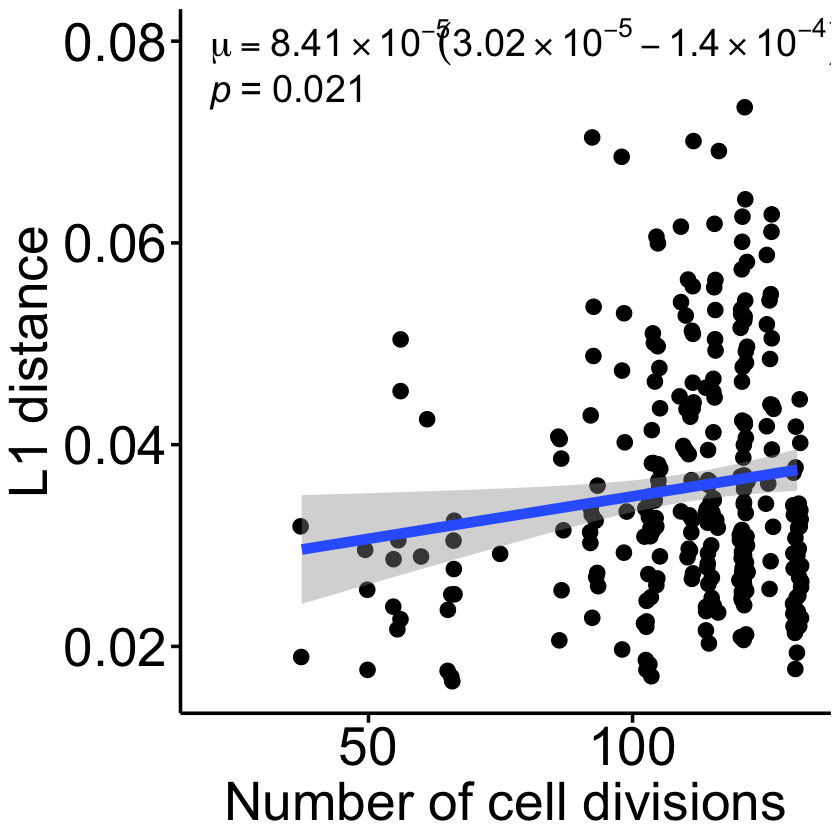

In [103]:
hmec_data %>% 
    ggplot(aes(divisions, l1)) +
    geom_jitter(size = 4,width = 0.8) +
    #ggbeeswarm::geom_quasirandom(size = 4,width = 1) +
    geom_smooth(method = "lm", size = 3) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    ) +
    annotate("text", 20, 0.08, label = mu_hmec_annotation, size = 8, parse = TRUE, hjust = 0) +
    annotate("text", 63, 0.08, label = mu_ci_hmec_annotation, size = 8, parse = TRUE, hjust = 0) +
    stat_cor(aes(label = ..p.label..), size = 8, label.y = 0.075)
ggsave("../plots/Figure2/mu_hmec.pdf", width=8)

## RPTEC

In [34]:
# directroy of all results
dir_list_rptec <-  list.files("../data/invitro_mu/",
                        pattern= "RPTEC", full.names = TRUE)

In [35]:
l <- lapply(
    dir_list_rptec,
    get_markerlengths_unsubtracted
)
markerlengths_rptec <- bind_rows(l)

RPTEC



### Heatmap

In [36]:
markerlengths_rptec <- markerlengths_rptec %>%
    group_by(subject, marker) %>%
    filter(any(str_detect(sample, "Root1"))) %>% 
    mutate(length = length - length[sample==str_subset(sample, "Root1")[1]]) %>% 
    ungroup()

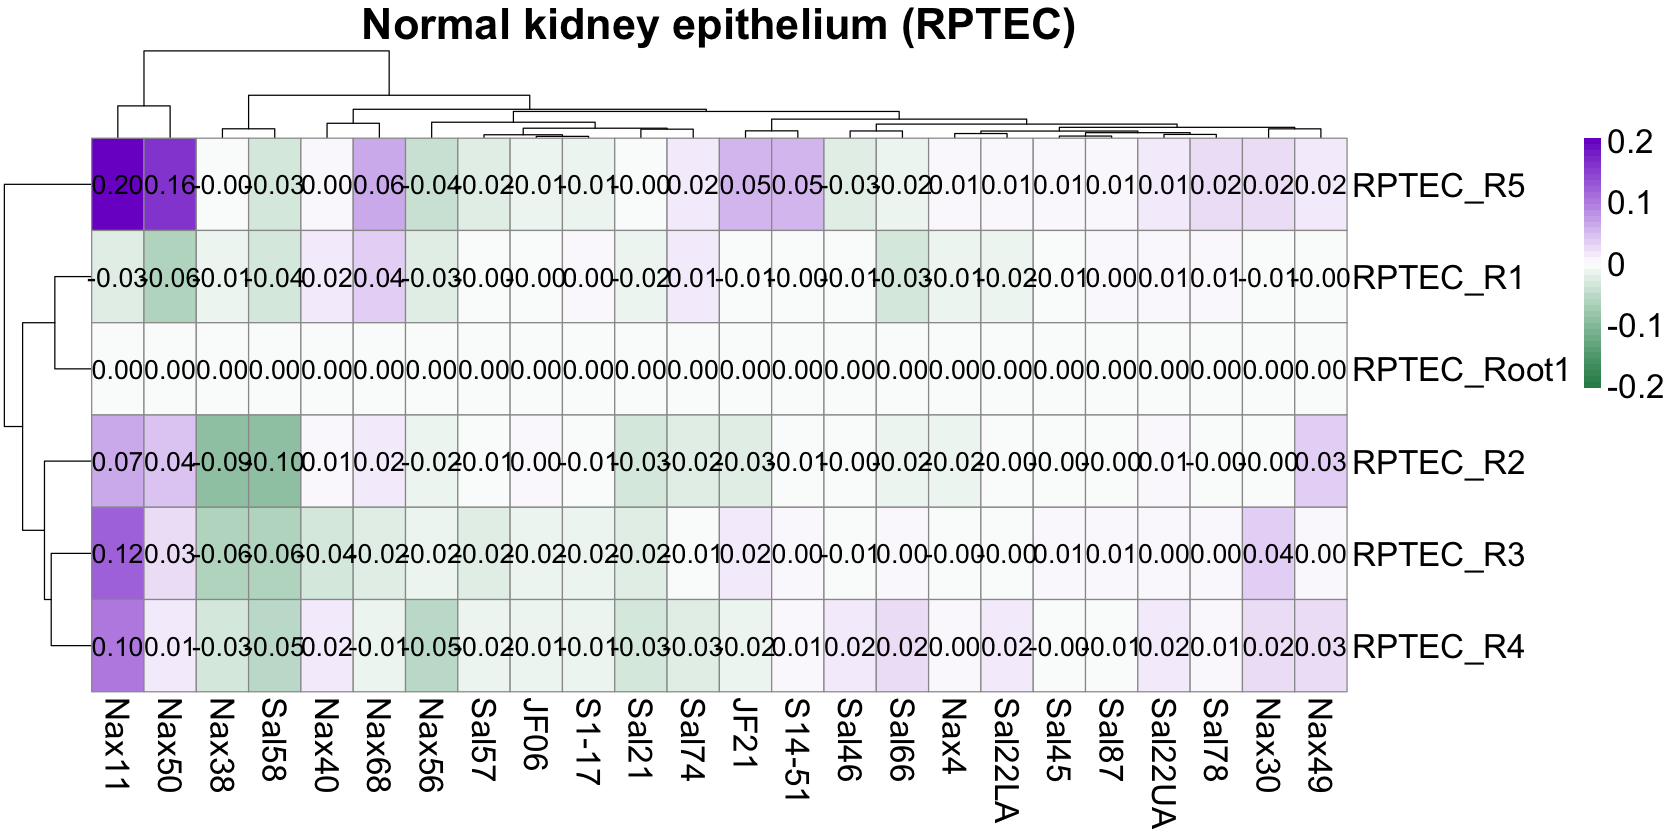

In [75]:
filtered_matrix <- markerlengths_rptec %>%
        select(-subject) %>%
        pivot_wider(names_from = marker, 
        values_from = length) %>% 
        column_to_rownames("sample") %>%
        as.matrix()
    
    minmax <- max(abs(filtered_matrix), na.rm = TRUE)
    
plot_title <- "Normal kidney epithelium (RPTEC)"
options(repr.plot.width=14, repr.plot.height=7)
    hm <- pheatmap::pheatmap(filtered_matrix,
        clustering_distance_rows = "manhattan",
        clustering_distance_cols = "manhattan",
        display_numbers = TRUE, number_color = "black", fontsize = 20,
        color = colorRampPalette(c("seagreen", "white", "purple3"))(42),
        na_col = "yellow", breaks = seq(-minmax, minmax, length.out = 43),
        main = plot_title
    )
ggsave("../plots/Supplementary_figures/rptec_hm.pdf", hm, height=13, width=30)

## L1 Distance

In [37]:
# find samples
samples <- markerlengths_rptec$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    dplyr::select(a, b)  


In [38]:
l1_l <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, markerlengths_rptec)

In [39]:
rptec_l1_tbl <- rbindlist(l1_l)

In [40]:
rptec_data <- rptec_l1_tbl %>%
    mutate(
        divisions = ifelse(a == "RPTEC_Root1" | b == "RPTEC_Root1", 47.44, 47.44 * 2),
        days = ifelse(a == "RPTEC_Root1" | b == "RPTEC_Root1", 30, 30 * 2)
    )

In [126]:
lm(l1 ~ divisions, data = rptec_data) %>%
    summary()


Call:
lm(formula = l1 ~ divisions, data = rptec_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0099361 -0.0052185 -0.0003573  0.0037579  0.0110136 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 2.004e-02  6.552e-03   3.059  0.00914 **
divisions   6.906e-05  7.974e-05   0.866  0.40213   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006907 on 13 degrees of freedom
Multiple R-squared:  0.05456,	Adjusted R-squared:  -0.01817 
F-statistic: 0.7502 on 1 and 13 DF,  p-value: 0.4021


In [41]:
rptec_just_divs <- rptec_data %>%
    select(a, b, divisions) 


In [42]:
rptec_boot <- bootstrap_mu(markerlengths_rptec, rptec_just_divs)

In [873]:
quantile(unlist(rptec_boot), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(rptec_boot), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"-7.53463e-05"

97.5% 
"2.019998e-04"

In [44]:
lower_ci_rptec <- sub("e", " %*% 10^", quantile(unlist(rptec_boot), 0.025) %>%
    format(scientific = TRUE))
upper_ci_rptec <- sub("e", " %*% 10^", quantile(unlist(rptec_boot), 0.975) %>%
    format(scientific = TRUE))

Manual entering bootstrap values from previous run to reduce computation time.

In [ ]:
lower_ci_rptec <- sub("e", " %*% 10^", "-7.53e-05")
upper_ci_rptec <- sub("e", " %*% 10^", "2.02e-04")

In [129]:
# calculating mutation rate based on slope
mu_rptec <- coef((lm(rptec_data$l1 ~ rptec_data$divisions)))[2]
mu_rptec_form <- sub("e", " %*% 10^", format(mu_rptec, digits=3, scientific = TRUE))
mu_rptec_annotation <- paste0("mu == ", mu_rptec_form)
mu_ci_rptec_annotation <- paste0("(", lower_ci_rptec, "-", upper_ci_rptec,")")

`geom_smooth()` using formula = 'y ~ x'
Saving 8 x 7 in image
`geom_smooth()` using formula = 'y ~ x'


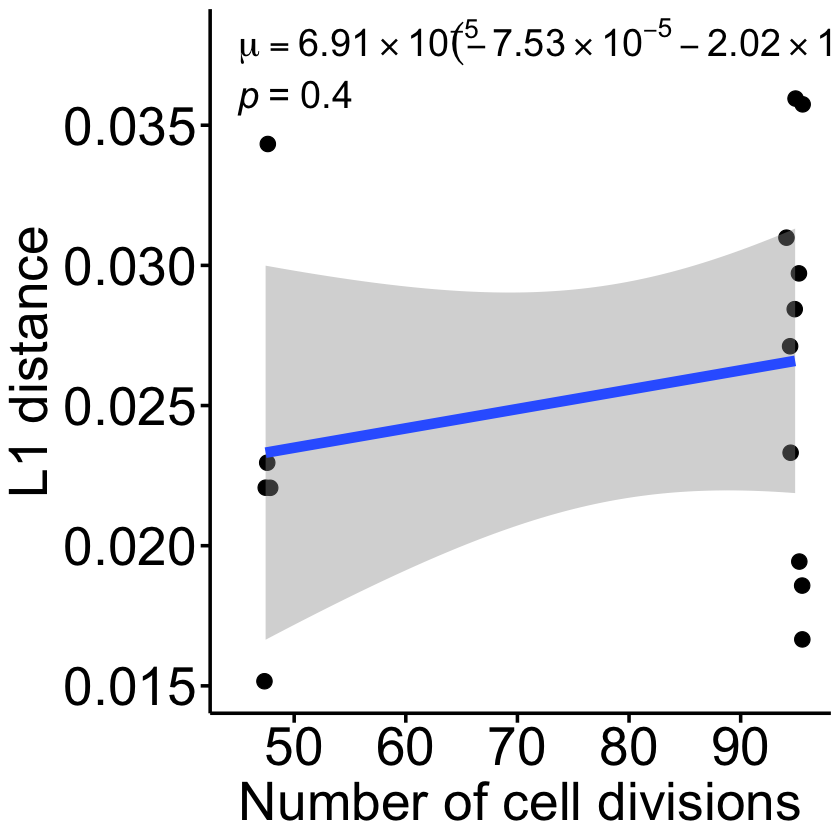

In [143]:
rptec_data %>% 
    ggplot(aes(divisions, l1)) +
    geom_jitter(size = 4,width = 0.8) +
    #ggbeeswarm::geom_quasirandom(size = 4,width = 1) +
    geom_smooth(method = "lm", size = 3) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    ) +
    annotate("text", 45, 0.038, label = mu_rptec_annotation, size = 8, parse = TRUE, hjust = 0) +
    annotate("text", 64, 0.038, label = mu_ci_rptec_annotation, size = 8, parse = TRUE, hjust = 0) +
    stat_cor(aes(label = ..p.label..), size = 8, label.y = 0.036)
ggsave("../plots/Figure2/mu_rptec.pdf", width=8)

In [146]:
markerlengths_rptec %>%
    filter(!str_detect(sample, "Root")) %>%
    pull(sample) %>%
    n_distinct()

[1] 5

## HT29

In [76]:
# directroy of all results
dir_list_ht29 <-  list.files("../data/invitro_mu/",
                        pattern= "HT29", full.names = TRUE)

In [77]:
l <- lapply(
    dir_list_ht29,
    get_markerlengths_unsubtracted
)
markerlengths_raw_ht29 <- bind_rows(l)

HT29



### Heatmap

In [78]:
markerlengths_ht29 <- markerlengths_raw_ht29 %>%
    group_by(subject, marker) %>%
    filter(any(str_detect(sample, "Root1"))) %>% 
    mutate(length = length - length[sample==str_subset(sample, "Root1")[1]]) %>% 
    ungroup()

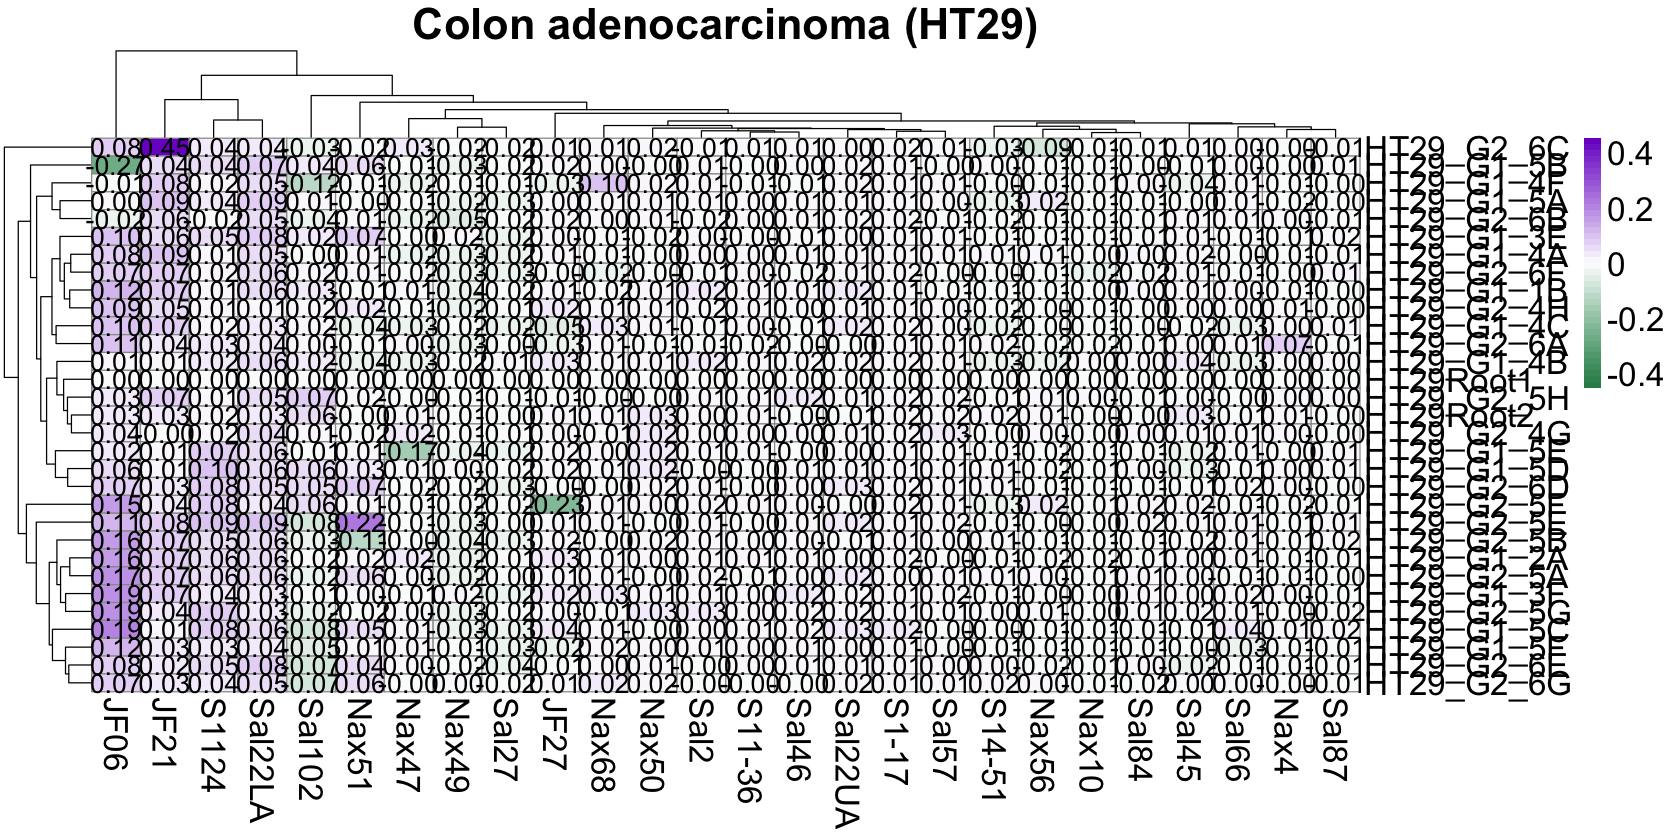

In [21]:
filtered_matrix <- markerlengths_ht29 %>%
    select(-subject) %>%
    # excluding markers that didn't amplify in all samples
        filter(any(str_detect(sample, "Root1")), !(marker %in% c("JF12", "Nax30", "Nax40"))) %>% 
        pivot_wider(names_from = marker, 
        values_from = length) %>% 
        column_to_rownames("sample") %>%
        as.matrix()
    
    minmax <- max(abs(filtered_matrix), na.rm = TRUE)
    
plot_title <- "Colon adenocarcinoma (HT29)"
options(repr.plot.width=14, repr.plot.height=7)
    hm <- pheatmap::pheatmap(filtered_matrix,
        clustering_distance_rows = "manhattan",
        clustering_distance_cols = "manhattan",
        display_numbers = TRUE, number_color = "black", fontsize = 20,
        color = colorRampPalette(c("seagreen", "white", "purple3"))(42),
        na_col = "yellow", breaks = seq(-minmax, minmax, length.out = 43),
        main = plot_title
    )
ggsave("../plots/Supplementary_figures/ht29_hm.pdf", hm, height=13, width=30)

## L1 Distance

In [79]:
markerlengths_ht29 <- markerlengths_raw_ht29 %>%
    group_by(marker) %>%
    filter(any(str_detect(sample, "Root1")), !(marker %in% c("JF12", "Nax30", "Nax40"))) %>% 
    mutate(length = length - length[sample==str_subset(sample, "Root1")[1]]) %>% 
    ungroup() 

In [80]:
# find samples
samples <- markerlengths_ht29$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_extract(a, "^[:upper:]+[:digit:]+"),
          sample_b=str_extract(b, "^[:upper:]+[:digit:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [81]:
l1_l <- lapply(1:nrow(combos), get_l1_r_for_all_combination, combos, markerlengths_ht29)

In [82]:
ht29_l1_tbl <- rbindlist(l1_l)

In [83]:
ht29_data <- ht29_l1_tbl %>%
    filter(a != "HT29Root2", b != "HT29Root2") %>%
    mutate(divisions = case_when(
        a == "HT29Root1" & str_detect(b, "_G1_") ~ 27.49271138,
        a == "HT29Root1" & str_detect(b, "_G2_") ~ 45.60432582,
        str_detect(a, "_G1_") & str_detect(b, "_G1_") ~ 27.49271138*2,
        str_detect(a, "_G2_") & str_detect(b, "_G2_") ~ 45.60432582*2,
        str_detect(a, "_G1_") & str_detect(b, "_G2_") ~ 27.49271138+45.60432582,
        str_detect(b, "_G1_") & str_detect(a, "_G2_") ~ 27.49271138+45.60432582),
        days = case_when(
        a == "HT29Root1" & str_detect(b, "_G1_") ~ 44,
        a == "HT29Root1" & str_detect(b, "_G2_") ~ 76,
        str_detect(a, "_G1_") & str_detect(b, "_G1_") ~ 44*2,
        str_detect(a, "_G2_") & str_detect(b, "_G2_") ~ 76*2,
        str_detect(a, "_G1_") & str_detect(b, "_G2_") ~ 44+76,
        str_detect(b, "_G1_") & str_detect(a, "_G2_") ~ 44+76,
    )
        ) 

In [84]:
lm(l1 ~ divisions, data = ht29_data) %>%
    summary()


Call:
lm(formula = l1 ~ divisions, data = ht29_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.011826 -0.004740 -0.001170  0.003836  0.024902 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.168e-02  1.431e-03  15.150   <2e-16 ***
divisions   2.377e-05  1.962e-05   1.211    0.227    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006307 on 433 degrees of freedom
Multiple R-squared:  0.003376,	Adjusted R-squared:  0.001074 
F-statistic: 1.467 on 1 and 433 DF,  p-value: 0.2265


In [85]:
ht29_just_divs <- ht29_data %>%
    select(a, b, divisions) 
markerlengths_ht29_boot <- markerlengths_ht29 %>%
    filter(sample!="HT29Root2") 

In [86]:
ht29_boot <- bootstrap_mu(markerlengths_ht29_boot, ht29_just_divs)

In [87]:
quantile(unlist(ht29_boot), 0.025) %>% 
    format(scientific = TRUE)
quantile(unlist(ht29_boot), 0.975) %>% 
    format(scientific = TRUE)

2.5% 
"-2.295279e-05"

97.5% 
"6.767945e-05"

In [55]:
lower_ci_ht29 <- sub("e", " %*% 10^", quantile(unlist(ht29_boot), 0.025) %>%
    format(scientific = TRUE))
upper_ci_ht29 <- sub("e", " %*% 10^", quantile(unlist(ht29_boot), 0.975) %>%
    format(scientific = TRUE))

Manual entering bootstrap values from previous run to reduce computation time.

In [88]:
lower_ci_ht29 <- sub("e", " %*% 10^", "-2.30e-05")
upper_ci_ht29 <- sub("e", " %*% 10^", "6.77e-05")

In [89]:
# calculating mutation rate based on slope
mu_ht29 <- coef((lm(ht29_data$l1 ~ ht29_data$divisions)))[2]
mu_ht29_form <- sub("e", " %*% 10^", format(mu_ht29, digits=3, scientific = TRUE))
mu_ht29_annotation <- paste0("mu == ", mu_ht29_form)
mu_ci_ht29_annotation <- paste0("(", lower_ci_ht29, "-", upper_ci_ht29,")")

`geom_smooth()` using formula = 'y ~ x'
Saving 8 x 7 in image
`geom_smooth()` using formula = 'y ~ x'


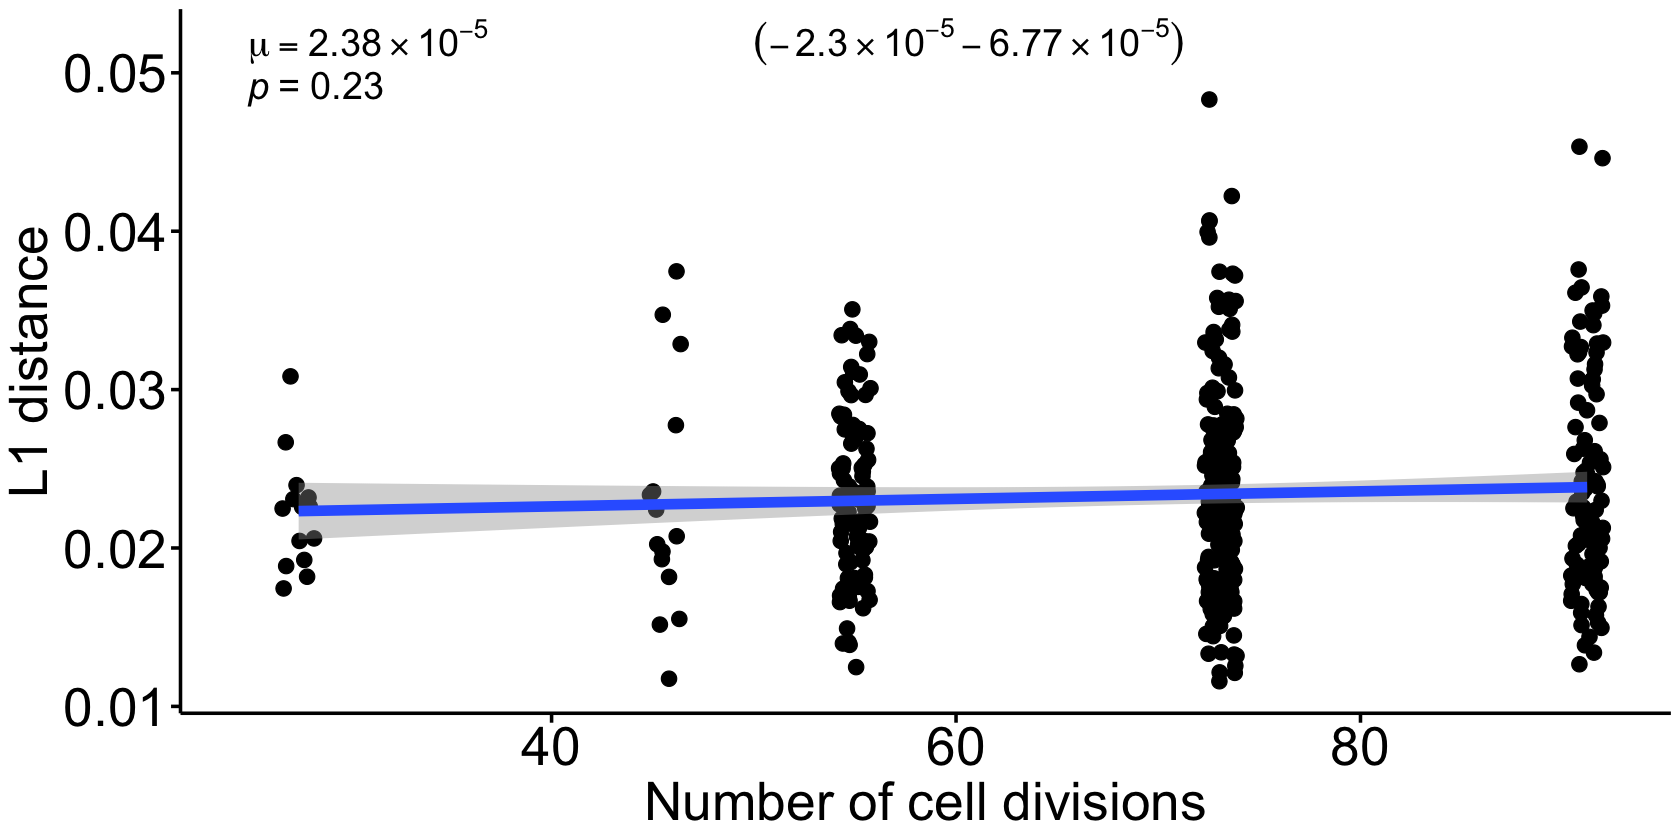

In [90]:
ht29_data %>% 
    ggplot(aes(divisions, l1)) +
    geom_jitter(size = 4,width = 0.8) +
    #ggbeeswarm::geom_quasirandom(size = 4,width = 1) +
    geom_smooth(method = "lm", size = 3) +
    theme_martin() +
    labs(
        x = "Number of cell divisions",
        y = "L1 distance"
    ) +
    annotate("text", 25, 0.052, label = mu_ht29_annotation, size = 8, parse = TRUE, hjust = 0) +
    annotate("text", 50, 0.052, label = mu_ci_ht29_annotation, size = 8, parse = TRUE, hjust = 0) +
    stat_cor(aes(label = ..p.label..), size = 8, label.y = 0.049)
ggsave("../plots/Figure2/mu_ht29.pdf", width=8)